In [2]:
import pandas as pd
import re
import os
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import shutil
import rasterio

%matplotlib widget

In [3]:
json_folder = r"C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoJson"
img_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\Naver'
tiff_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoTiff'

In [4]:
files = glob.glob(os.path.join(tiff_folder,'*.tif'))
files

['C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\클럽디거창CCL14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\클럽디거창CCL15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\클럽디거창CCL18.tif']

In [5]:
target_courseName = '거창'

In [6]:
out_tiff = [ x for x in files if 'L18' in x and target_courseName in x][0]

#### 이미지를 읽어온다 Raterio활용. crs를 5179로

In [7]:
import rasterio
import cv2

with rasterio.open(out_tiff, mode='r+') as dataset:
  image_org = dataset.read()
  image_org = image_org.transpose(1, 2, 0)

In [8]:
dataset.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

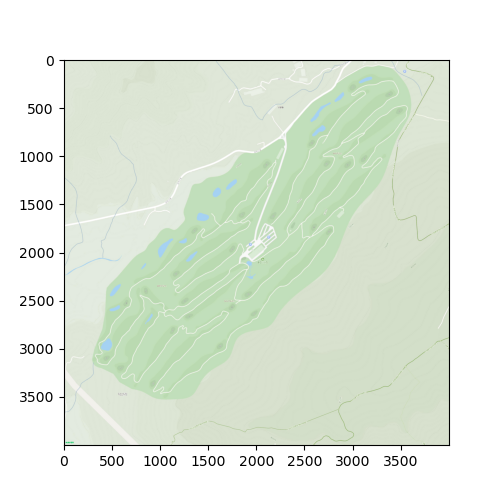

In [9]:
image = cv2.medianBlur(image_org,5)

fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(image)

In [15]:
image_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2HSV)
%matplotlib widget 

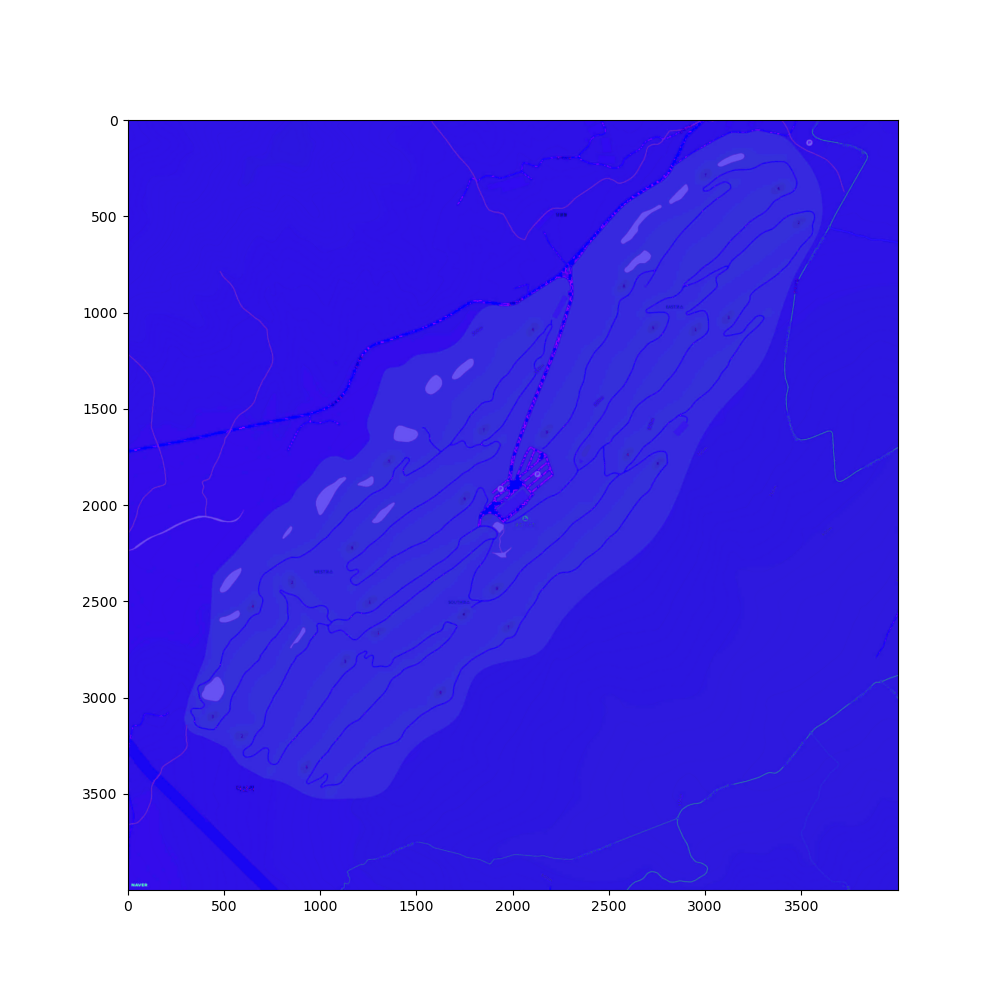

data coords 1020.2792207792209 1978.7207792207791, pixel coords 499 324
[[[1978.7207792207791, 1020.2792207792209]]] [array([103,  82, 243], dtype=uint8)]


In [16]:
import numpy as np

from matplotlib.backend_bases import MouseButton
from matplotlib.widgets import Button

input_point = []
input_label = []
 


fig = plt.figure(figsize=(10,10))
plt.imshow(hsv)
plt.axis('on')


def on_click(event):

    if event.inaxes and event.button is MouseButton.LEFT:
      print(f'data coords {event.xdata} {event.ydata},',
            f'pixel coords {event.y} {event.x}')

      plt.plot(event.xdata,event.ydata,'bo') 
      input_point.append([[event.ydata, event.xdata]])
      input_label.append(hsv[int(event.ydata), int(event.xdata),:])
      print(input_point, input_label)


    if  event.inaxes and event.button is MouseButton.RIGHT:
        print('disconnecting callback')
        plt.disconnect(binding_id)


plt.connect('button_press_event', on_click)


plt.show()

In [17]:
def nothing(x):
    pass
  
# Create a window
cv2.namedWindow('image')

# Create trackbars for color change
# Hue is from 0-179 for Opencv
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Set default value for Max HSV trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize HSV min/max values
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # Get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Set minimum and maximum HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print if there is a change in HSV value
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display result image
    result = cv2.resize(result, (500, 500))  
    cv2.imshow('image', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 3 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 5 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 6 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 8 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 9 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 11 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 14 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 16 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 20 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 22 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 24 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 26 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 27 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255

In [71]:
%matplotlib inline


In [42]:
## Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

## Mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
# 65,  41, 223
#  67,  48, 218
#  68,  38, 206]
# mask = cv2.inRange(hsv, (57, 38, 73), (80, 55,217)) # green
mask = cv2.inRange(hsv, (67, 47, 217), (69, 49,219))
mask = cv2.inRange(hsv, (24, 29, 217), (76, 77,221))
image2 = cv2.bitwise_and(image, image, mask = mask)

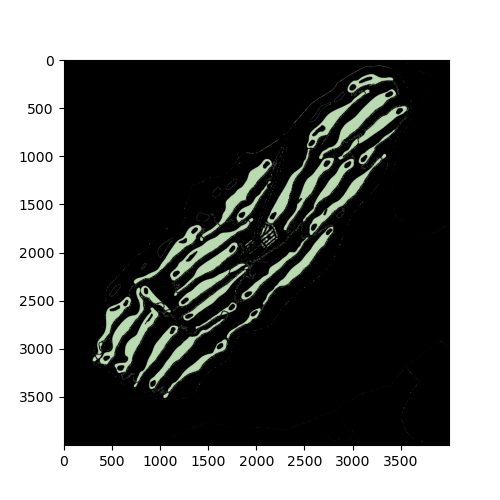

In [43]:
plt.figure(figsize=(5,5))
plt.imshow(image2)
plt.axis('on')
plt.show()

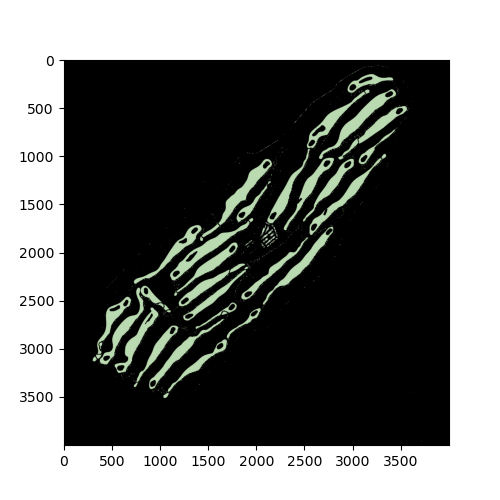

In [47]:
im1_blurred = cv2.medianBlur(image2 ,5)

fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(im1_blurred)

In [48]:
import numpy as np 

pixel_values = im1_blurred.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(im1_blurred.shape)

mask = labels.reshape(im1_blurred.shape[:2]).astype(np.uint8)

if np.where(centers == [0,0,0])[0][0] == 1:
  mask = np.logical_not(mask).astype(np.uint8)

In [49]:
plt.imshow(mask, cmap = 'gray')

In [50]:
contours, hierarchy = cv2.findContours(image=mask.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

In [51]:
len(contours)

1698

In [55]:
approx_contours = []

for c in contours:
    epsilon = 0.001*cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,epsilon,True)
    
    if cv2.contourArea(c) > 5000:
        approx_contours.append(approx)
    print(c.shape,approx.shape)

(10, 1, 2) (9, 1, 2)
(4, 1, 2) (3, 1, 2)
(9, 1, 2) (7, 1, 2)
(6, 1, 2) (6, 1, 2)
(6, 1, 2) (4, 1, 2)
(14, 1, 2) (12, 1, 2)
(8, 1, 2) (6, 1, 2)
(170, 1, 2) (106, 1, 2)
(17, 1, 2) (10, 1, 2)
(5, 1, 2) (4, 1, 2)
(20, 1, 2) (8, 1, 2)
(32, 1, 2) (11, 1, 2)
(8, 1, 2) (6, 1, 2)
(18, 1, 2) (11, 1, 2)
(11, 1, 2) (5, 1, 2)
(4, 1, 2) (4, 1, 2)
(6, 1, 2) (4, 1, 2)
(12, 1, 2) (10, 1, 2)
(23, 1, 2) (14, 1, 2)
(23, 1, 2) (12, 1, 2)
(12, 1, 2) (9, 1, 2)
(10, 1, 2) (9, 1, 2)
(11, 1, 2) (7, 1, 2)
(4, 1, 2) (4, 1, 2)
(14, 1, 2) (10, 1, 2)
(1, 1, 2) (1, 1, 2)
(10, 1, 2) (6, 1, 2)
(5, 1, 2) (4, 1, 2)
(13, 1, 2) (9, 1, 2)
(18, 1, 2) (10, 1, 2)
(15, 1, 2) (9, 1, 2)
(8, 1, 2) (4, 1, 2)
(13, 1, 2) (10, 1, 2)
(7, 1, 2) (5, 1, 2)
(14, 1, 2) (8, 1, 2)
(1, 1, 2) (1, 1, 2)
(19, 1, 2) (16, 1, 2)
(13, 1, 2) (9, 1, 2)
(16, 1, 2) (10, 1, 2)
(2, 1, 2) (2, 1, 2)
(15, 1, 2) (5, 1, 2)
(6, 1, 2) (6, 1, 2)
(18, 1, 2) (11, 1, 2)
(5, 1, 2) (4, 1, 2)
(120, 1, 2) (72, 1, 2)
(6, 1, 2) (6, 1, 2)
(9, 1, 2) (6, 1, 2)
(20, 1, 2) (16,

In [56]:
image_copy = image_org.copy()
# c = max(contours, key = cv2.contourArea)
image_copy = cv2.drawContours(image=image_copy, contours=approx_contours, contourIdx=-1, color=(255,1,1), thickness=2, lineType=cv2.LINE_AA)

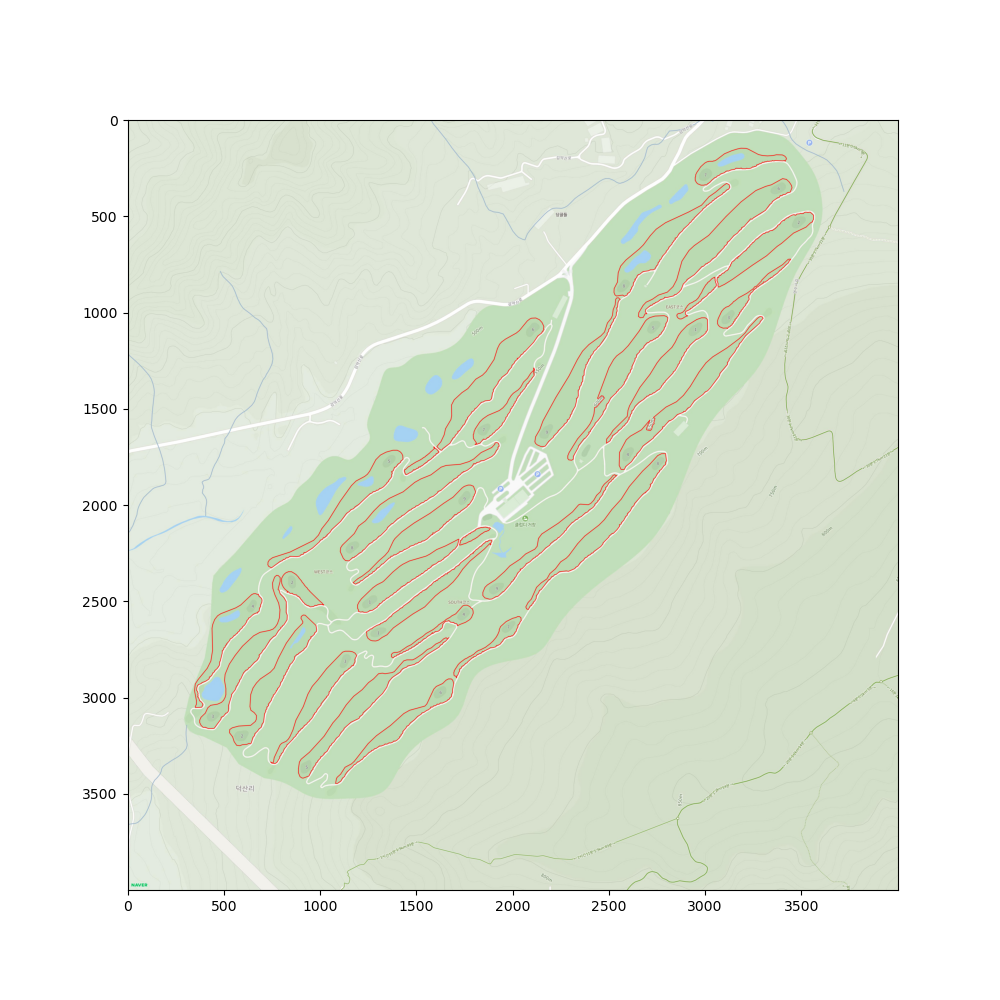

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(image_copy)